Load up experiment & annotations

In [17]:
import sys
sys.path.append('/tmp/pycharm_project_59/src')

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

%load_ext autoreload
%autoreload 2


from classification.classification import classify_all
from data_reading.phyphox import read_experiment
from features import extract_timeseries_features
from file_handling import get_sub_directories
from preprocessing import align_data, segment_windows, merge_left_and_right_chunk
from visualization import plot_duration_histogram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
experiment_dir_path = "../../data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
complete_experiments_indices = [2]
# Anne marvin julius fabi cilly
experiment_dirs = [experiment_dirs[i] for i in complete_experiments_indices]
print(experiment_dirs)
sample_rate = 50
chunks = {"right": [], "left": []}
null_chunks = {"right": [], "left": []}
y_columns = ["start", "end", "label", "hand"]
y = pd.DataFrame(columns=y_columns)
#del experiment_dirs[1]
for directory in experiment_dirs:
    offsets = {}
    with open(directory + "/offset.txt") as f:
        for line in f:
           (key, val) = line.split(": ")
           offsets[key.lower()] = val

    data_frames = read_experiment(directory, offsets=offsets)
    data_frames = {key : align_data(data_frame, listening_rate=1000/sample_rate, reference_sensor=None) for key, data_frame in data_frames.items()}

    y_user = pd.read_csv(directory + "/annotations.tsv", delimiter="\t", header=None)
    hands = pd.read_csv(directory + "/hands.tsv", delimiter="\t", header=None)
    y_user = y_user.iloc[:, [3,5,8]]
    hands = hands.iloc[:, [8]]
    y_user = pd.concat([y_user, hands], axis=1)
    y_user.columns = y_columns
    y = pd.concat([y, y_user], axis=0)

    # iterate over the annotations and split the timeseries in chunks
    for key, df in data_frames.items():
        if key in chunks:
            chunks[key] += [df.iloc[int(annotation["start"]*sample_rate):int(annotation["end"]*sample_rate)] for i, annotation in y_user.iterrows()]
            # null chunks are everything in between annotations
            null_chunks[key] += [df.iloc[int(annotation["end"]*sample_rate):int(y_user.iloc[i+1:i+2]["start"]*sample_rate)] for i, annotation in y_user.iterrows() if i < len(y_user)-1]

['../../data/phyphox/full recordings/Fabi']


In [20]:
experiment_dirs

['../../data/phyphox/full recordings/Fabi']

Preprocess data

No handles with labels found to put in legend.


Mean 7.57 +/- 11.83


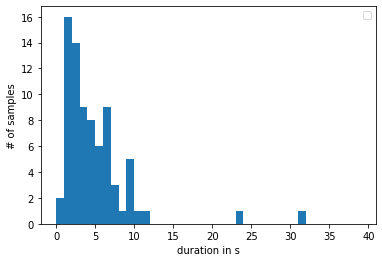

In [21]:
plot_duration_histogram(chunks["right"])

No handles with labels found to put in legend.


Mean 7.68 +/- 22.98


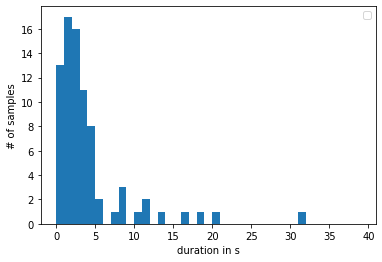

In [22]:
plot_duration_histogram(null_chunks["right"])

In [23]:
# append the activity label (as int) and the action id to the dataframe
# we need to do this to be able to extract time series features later

labels = y.loc[:, "label"].unique()
label_ids = { l: i for l,i in zip(labels, range(0,len(labels))) }

# list of tuples (left chunk, right chunk)
chunks_two_handed = []
# list of chunks
chunks_one_handed = []

y = y.replace(label_ids)


for i, cl in zip(range(len(y)), y.iterrows()):
    label_id = int(cl[1]["label"])
    action_id = i
    two_handed_chunk = []
    for hand, chunk_list in chunks.items():
        c = chunk_list[i]
        chunk_hand = cl[1]["hand"]
        two_handed_chunk.append(c)
        one_handed_chunk = c
        one_handed_chunk["action_id"] = action_id
        if chunk_hand == hand:
            #c["activity"] = label_id
            chunks_one_handed.append(one_handed_chunk)
    two_handed_chunk = merge_left_and_right_chunk(two_handed_chunk[0], two_handed_chunk[1], action_id)
    chunks_two_handed.append(two_handed_chunk)

labels = y.loc[:, "label"].squeeze()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Feature extraction for 2 handed activities

In [24]:
window_size = 100

In [25]:
# prepare null chunks
null_class_chunks = []

# TODO: assert that this list is disjoint to the list of action ids from activities
null_action_ids = range(len(chunks_two_handed),len(chunks_two_handed)+len(null_chunks["right"]))
for c_r, c_l, action_id in zip(null_chunks["right"], null_chunks["left"], null_action_ids):
    if len(c_l):
        c_both = merge_left_and_right_chunk(c_l, c_r, action_id)
        null_class_chunks.append(c_both)

In [26]:
chunks_two_handed[1]

,linear_acceleration x,linear_acceleration y,linear_acceleration z,gyroscope x,gyroscope y,gyroscope z,acceleration x,acceleration y,acceleration z,action_id,linear_acceleration x_right,linear_acceleration y_right,linear_acceleration z_right,gyroscope x_right,gyroscope y_right,gyroscope z_right,acceleration x_right,acceleration y_right,acceleration z_right
index,,,,,,,,,,,,,,,,,,,
00:00:27.492701,-0.370233,-0.128051,-0.781167,0.016498,-0.122322,-0.014889,4.972368,6.272657,5.585640,1,-1.088793,0.186782,0.283973,-0.053536,0.146358,-1.042316,-3.231334,9.977078,1.130937
00:00:27.512701,-0.585994,-0.266211,-1.099674,-0.050855,-0.150729,-0.038102,4.908700,6.486166,5.664562,1,-1.024536,0.207923,0.233112,-0.022836,0.040147,-0.925410,-3.263363,9.851446,1.246954
00:00:27.532701,-0.803674,-0.232033,-1.736965,-0.082658,-0.210110,-0.043735,5.035639,6.300685,5.479920,1,-0.911537,0.184554,0.139625,0.034894,-0.050724,-0.766534,-3.317547,9.680814,1.401553
00:00:27.552701,-1.458935,-0.080341,-2.650625,-0.098656,-0.252738,-0.056197,5.028939,6.250519,5.524320,1,-0.774675,0.075361,0.043319,0.101885,-0.120377,-0.565348,-3.361969,9.539197,1.522800
00:00:27.572701,-2.678092,0.513560,-2.922305,-0.113314,-0.234653,-0.095999,5.124808,6.452843,5.801552,1,-0.670072,-0.046705,-0.022794,0.139087,-0.166360,-0.350951,-3.365289,9.363176,1.587271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:00:30.592701,0.856633,0.747703,3.415010,-0.404577,1.991521,0.048862,6.772351,9.634151,5.633311,1,0.241073,0.103058,-0.081686,-0.297562,0.416405,0.314431,-1.611758,10.210417,2.205326
00:00:30.612701,-0.086826,0.897526,2.497493,-0.586268,2.408180,0.357014,6.897121,9.700348,5.595221,1,0.429295,0.169685,-0.157713,-0.296216,0.418890,0.228426,-1.628220,10.146359,2.297881
00:00:30.632701,-0.799413,0.867639,2.008860,-0.849987,2.546958,0.653957,6.551300,10.231736,6.094499,1,0.514841,0.109295,-0.124108,-0.284490,0.431723,0.154723,-1.807413,10.029268,2.338660


## Classification step 1: OCD activities vs null class samples

In [27]:
# new label id for ocd activities
labels_ocd_acts = pd.Series([labels.max()+2] * len(chunks_two_handed))
chunks_ocd_activities, labels_ocd_acts = segment_windows(chunks_two_handed, labels_ocd_acts.to_numpy(), window_size)

/tmp/pycharm_project_59/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


In [28]:
chunks_ocd_activities[9]

,linear_acceleration x,linear_acceleration y,linear_acceleration z,gyroscope x,gyroscope y,gyroscope z,acceleration x,acceleration y,acceleration z,action_id,linear_acceleration x_right,linear_acceleration y_right,linear_acceleration z_right,gyroscope x_right,gyroscope y_right,gyroscope z_right,acceleration x_right,acceleration y_right,acceleration z_right
index,,,,,,,,,,,,,,,,,,,
00:01:09.492701,-4.359783,1.163866,-2.281875,1.530990,1.466556,0.507772,-6.360746,9.352197,6.461012,"(10, 0)",-1.045972,-0.488504,0.610756,-0.286338,1.035203,-0.056395,-2.723303,9.075305,0.687982
00:01:09.512701,-0.134731,0.320295,-1.127615,0.727148,1.283530,-0.369780,-12.595941,13.457861,8.847542,"(10, 0)",-1.282565,-0.820231,0.755533,-0.295330,1.036743,0.023984,-2.597854,9.140406,0.561636
00:01:09.532701,1.739704,0.890860,-1.628067,0.080092,-0.263063,-0.711257,-13.335608,11.078470,8.528347,"(10, 0)",-1.472860,-1.074009,0.820523,-0.288998,1.028004,0.118325,-2.405483,9.263854,0.427738
00:01:09.552701,3.979499,1.866770,-1.692864,0.168631,-2.270298,-0.003052,-9.254243,5.840477,7.335676,"(10, 0)",-1.661480,-1.227975,0.832166,-0.271905,1.003408,0.231381,-2.180810,9.353277,0.370399
00:01:09.572701,4.878754,2.963917,0.023497,0.088800,-3.703383,0.680782,-4.976879,6.207997,8.716777,"(10, 0)",-1.756568,-1.053502,0.934873,-0.258213,0.995685,0.334259,-1.983759,9.444472,0.368528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:01:11.392701,-0.104496,0.561814,-0.637571,-0.012828,0.014340,-0.108427,1.247051,6.068675,8.785923,"(10, 0)",-0.641316,-0.409680,0.133843,0.068822,-0.366043,-0.234534,-2.854485,9.317508,0.734261
00:01:11.412701,-0.859510,0.763728,-4.855501,-0.049450,0.124267,-0.150369,1.032589,6.356214,8.586157,"(10, 0)",-0.304555,-0.298983,0.055029,0.059826,-0.238533,-0.227227,-3.152616,9.287551,0.858896
00:01:11.432701,0.911389,2.246841,1.431691,-0.073896,0.033180,-0.132724,0.835715,6.217923,7.396869,"(10, 0)",0.004733,-0.225681,0.215965,0.046456,-0.153766,-0.229598,-3.491567,9.239141,1.049404


In [29]:
null_labels = pd.Series([labels.max()+1] * len(null_class_chunks))
null_class_chunks, null_labels = segment_windows(null_class_chunks, null_labels.to_numpy(), window_size)

In [30]:
null_class_chunks[9]

# TODO: assert that len(null_class_chunks.columns) == len(chunks_ocd_activities.columns)


,linear_acceleration x,linear_acceleration y,linear_acceleration z,gyroscope x,gyroscope y,gyroscope z,acceleration x,acceleration y,acceleration z,linear_acceleration x_right,linear_acceleration y_right,linear_acceleration z_right,gyroscope x_right,gyroscope y_right,gyroscope z_right,acceleration x_right,acceleration y_right,acceleration z_right,action_id
index,,,,,,,,,,,,,,,,,,,
00:01:29.569772,1.263085,3.189597,0.920873,-0.321365,0.609117,0.385127,-4.863591,9.086540,3.036292,-0.562614,2.634504,2.350758,-0.396834,0.406612,-0.920671,8.808432,4.641807,5.571854,"(94, 0)"
00:01:29.589772,1.506030,2.195407,1.751308,-0.272956,0.806549,0.451667,-4.518248,9.133571,2.943458,-0.005909,3.460667,2.825259,-0.604520,-0.335594,-0.735784,7.759564,4.866624,4.616718,"(94, 0)"
00:01:29.609772,2.077151,0.554158,2.488619,-0.228489,1.021594,0.526260,-3.976565,9.245862,2.722455,0.819687,3.181781,3.579078,-0.703569,-1.139057,-0.514912,7.076611,5.165260,4.080172,"(94, 0)"
00:01:29.629772,2.278893,-0.989600,3.182509,-0.240000,1.154853,0.571900,-3.585083,9.621358,2.469998,1.383024,1.197434,3.641745,-0.772172,-1.796429,-0.315399,6.689387,5.731873,3.956200,"(94, 0)"
00:01:29.649772,1.675401,-1.798125,3.627219,-0.306604,1.157445,0.537467,-3.492388,10.371596,2.222475,0.862079,-0.438175,2.461898,-0.842794,-2.096567,-0.189592,6.501017,6.226345,4.481989,"(94, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:01:31.469772,1.178447,-0.772630,1.405946,-0.489389,1.411204,-1.254167,-4.256511,12.877248,2.063102,0.171141,-2.743866,0.616238,0.091043,-0.167791,1.989277,4.539542,7.039182,5.796877,"(94, 0)"
00:01:31.489772,0.925837,0.266513,1.125277,-0.484258,1.321062,-1.107530,-3.567083,11.912238,2.153521,-0.589621,-3.848572,-0.091727,0.103201,-0.291794,1.861521,4.473043,6.641968,5.236540,"(94, 0)"
00:01:31.509772,0.393577,2.294306,0.485914,-0.469384,1.245060,-0.937454,-2.572405,10.372484,2.304426,-0.960781,-3.381027,-0.822062,0.114970,-0.465954,1.719973,4.513315,6.414759,4.826857,"(94, 0)"


### Feature extraction for OCD activities vs non-OCD activities

In [31]:
null_classification_concat = pd.concat(chunks_ocd_activities + null_class_chunks).reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [32]:
#null_classification_concat = null_classification_concat.drop(columns=["acceleration x", "acceleration x_right", "acceleration y", "acceleration y_right", "acceleration z", "acceleration z_right"])
#display(null_classification_concat)
null_classification_concat["action_id"].nunique()

541

In [ ]:
features_two_handed_null_test = extract_timeseries_features(null_classification_concat)

Feature Extraction:  60%|██████    | 6/10 [03:07<02:00, 30.14s/it]

### Feature selection for OCD activities vs non-OCD activities

In [ ]:
labels_null_classification = pd.concat([labels_ocd_acts, null_labels])

In [ ]:
labels_null_classification

In [ ]:
impute(features_two_handed_null_test)
X_two_handed_selected_null_test = select_features(features_two_handed_null_test, labels_null_classification)
X_two_handed_selected_null_test

In [ ]:
# TODO: feature visualization: scatter plot - explain what happens

In [ ]:
scaler = StandardScaler()
X_null_classification = scaler.fit_transform(X_two_handed_selected_null_test)

### Train models and score results

In [ ]:
print("Two handed classification")
classify_all(X_null_classification, labels_null_classification)

In [ ]:
# TODO: plot feature importance (which feature has the most impact on the results)

sns.pairplot(X_null_classification[:, :10])


In [ ]:
chunks_two_handed_segmented, labels = segment_windows(chunks_two_handed, labels.to_numpy(), window_size)


### Feature extraction for 2 handed classifier of activities against each other

In [ ]:
df_against = pd.concat(chunks_two_handed).drop(columns=["acceleration x", "acceleration x_right", "acceleration y", "acceleration y_right", "acceleration z", "acceleration z_right"]).reset_index(drop=True)
df_against

In [ ]:
features_two_handed = extract_timeseries_features(df_against)

In [ ]:
features_two_handed.replace([np.inf, -np.inf], np.nan, inplace=True)
features_two_handed.dropna(inplace=True, axis=1)
features_two_handed

### Feature selection for 2 handed classifier of activities against each other

In [ ]:
# Off-the-shelve feature selection from tsfresh

impute(features_two_handed)
X_two_handed_selected = select_features(features_two_handed, pd.Series(labels))
X_two_handed_selected

In [ ]:
labels

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X_two_handed_selected)

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_two_handed_selected = sel.fit_transform(X)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_two_handed_selected = SelectKBest(f_classif, k=2000).fit_transform(X, labels)
X_two_handed_selected

Train models and score results

In [ ]:
print("Two handed classification")
classify_all(X, labels, label_ids)

In [ ]:
print("Two handed classification")
classify_all(X, labels, label_ids)

In [ ]:
labels

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X_two_handed_selected)

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_two_handed_selected = sel.fit_transform(X)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_two_handed_selected = SelectKBest(f_classif, k=2000).fit_transform(X, labels)
X_two_handed_selected

Train models and score results

In [ ]:
print("Two handed classification")
classify_all(X, labels, label_ids)